# Purpose of Notebook

The purpose of this notebook is to offer an example answer to the Guided Project for Logistic Regression in Python course. Since the choice of model predictors is up to the student, results can differ. Use this solution as a guide to how to structure your own answer.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Load in the heart disease dataset
heart = pd.read_csv("heart_disease.csv")

# Exploring The Dataset

In [3]:
# Columns in the dataset
heart.columns

Index(['Unnamed: 0', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'present'],
      dtype='object')

The `present` column is our binary outcome of interest. `0` encodes the absence of any heart disease, while `1` encodes the presence. 

Note: the original dataset actually has a multiclass version of the problem, based on heart disease severity. We've reduced it to a binary case for simplicity. 

In [4]:
heart.head

<bound method NDFrame.head of      Unnamed: 0  age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  \
0             1   63    1   1       145   233    1        2      150      0   
1             2   67    1   4       160   286    0        2      108      1   
2             3   67    1   4       120   229    0        2      129      1   
3             4   37    1   3       130   250    0        0      187      0   
4             5   41    0   2       130   204    0        2      172      0   
..          ...  ...  ...  ..       ...   ...  ...      ...      ...    ...   
292         293   57    0   4       140   241    0        0      123      1   
293         294   45    1   1       110   264    0        0      132      0   
294         295   68    1   4       144   193    1        0      141      0   
295         296   57    1   4       130   131    0        0      115      1   
296         297   57    0   2       130   236    0        2      174      0   

     oldpeak  slope  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2567b9cd10>]],
      dtype=object)

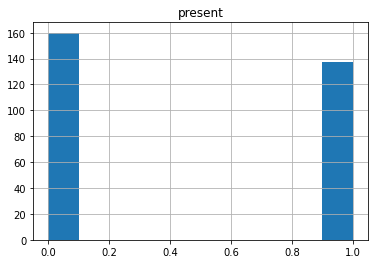

In [5]:
# Checking the outcome
heart.hist("present")

There's almost an equal number of cases and non-cases in the dataset.

In [6]:
# Checking potential predictors
heart.groupby("present").agg(
    {
        "age": "mean",
        "sex": "mean",
        "cp": "mean",
        "trestbps": "mean",
        "chol": "mean",
        "fbs": "mean",
        "restecg": "mean",
        "thalach": "mean",
        "exang": "mean",
        "oldpeak": "mean",
        "slope": "mean",
        "ca": "mean",
        "thal": "mean"
    }
)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
present,,,,,,,,,,,,,
0,52.643750,0.556250,2.793750,129.175000,243.493750,0.143750,0.843750,158.581250,0.143750,0.598750,1.412500,0.275000,3.787500
1,56.759124,0.817518,3.583942,134.635036,251.854015,0.145985,1.175182,139.109489,0.540146,1.589051,1.824818,1.145985,5.832117


Some columns have a small, but noticeable difference when stratified by predictors. Based on the differences and some knowledge about heart disease, these seem like good candidates for predictors:

1. `age`
2. `thalach` (maximum heart rate achieved)
3. `restecg` (resting ECG)
4. `ca` (number of vessels colored by fluoroscopy)

# Dividing The Data

We'll use a 70-30 split of the dataset for the training and test sets.

In [7]:
X = heart[["age", "thalach", "restecg", "ca"]]
y = heart["present"]

# 70% for training set, 30% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [8]:
# Checking for separation in the datasets
print("Y_train: ", sum(y_train == 0))
print("Y_train: ", sum(y_train == 1))
print("Y_test: ", sum(y_test == 0))
print("Y_test: ", sum(y_test == 1))

Y_train:  109
Y_train:  98
Y_test:  51
Y_test:  39


We confirm above that there are both cases and non-cases in both the training and test sets

# Build The Model

In [9]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [10]:
# Checking the various metrics for the model
acc = model.score(X_train, y_train)

predictions = model.predict(X_train)
tp = sum((predictions == 1) & (y_train == 1))
fp = sum((predictions == 1) & (y_train == 0))
tn = sum((predictions == 0) & (y_train == 0))
fn = sum((predictions == 0) & (y_train == 1))
sens = tp / (tp + fn)
spec = tn / (tn + fp)

print("Training Accuracy: ", acc)
print("Training Sensitivity: ", sens)
print("Training Specificity: ", spec)

Training Accuracy:  0.7681159420289855
Training Sensitivity:  0.6632653061224489
Training Specificity:  0.8623853211009175


Overall the training accuracy was about 76%, the sensitivity was 66%, and the specificity was 86%. Based on these metrics, the model seems to perform better for non-cases.

# Interpreting The Model Coefficients

In [11]:
coefs = ["age", "thalach", "restecg", "ca"]

# Checking in terms of log-odds
for coef, val  in zip(coefs, model.coef_[0]):
    print(coef, ":", round(val, 2))

age : -0.02
thalach : -0.04
restecg : 0.39
ca : 1.18


In [12]:
# Checking in terms of odds
for coef, val  in zip(coefs, model.coef_[0]):
    print(coef, ":", round(np.exp(val), 2))

age : 0.98
thalach : 0.96
restecg : 1.47
ca : 3.25


- Higher age and maximum heart rate (`thalach`) is associated with lower odds of heart disease holding the other predictors constant, but both of these odds ratios are close to 1.
- Resting ECG and the number of colored vessels are associated with higher odds of heart disease holding the other predictors constant. These increases seem to be moderate and high, respectively (a 47% increase and 225% (!) increase).

# Final Model Evaluation

In [13]:
# Checking the various metrics for the model (test set)
acc = model.score(X_test, y_test)

predictions = model.predict(X_test)
tp = sum((predictions == 1) & (y_test == 1))
fp = sum((predictions == 1) & (y_test == 0))
tn = sum((predictions == 0) & (y_test == 0))
fn = sum((predictions == 0) & (y_test == 1))
sens = tp / (tp + fn)
spec = tn / (tn + fp)

print("Test Accuracy: ", acc)
print("Test Sensitivity: ", sens)
print("Test Specificity: ", spec)

Test Accuracy:  0.7555555555555555
Test Sensitivity:  0.7948717948717948
Test Specificity:  0.7254901960784313


# Drawing Conclusions

Test accuracy was 75%, sensitivity was 79%, and specificity was 72%. Compared to the training set, the accuracy didn't change much, while the model fared better with cases and worse with non-cases. This is potentially useful since this application is health-based. We might be more interested in being better at identifying cases than non-cases.